# PyTorch Metric Learning
See the documentation [here](https://kevinmusgrave.github.io/pytorch-metric-learning/)

## Install the packages

In [1]:
!pip install pytorch-metric-learning
!pip install -q faiss-gpu
!git clone https://github.com/akamaster/pytorch_resnet_cifar10

fatal: destination path 'pytorch_resnet_cifar10' already exists and is not an empty directory.


## Import the packages

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from pytorch_resnet_cifar10 import resnet
from torchvision import datasets, transforms
import torchvision.models
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder
%load_ext autoreload
%autoreload 2

## Create helper functions

In [4]:
def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Create the dataset and load the trained model

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)

dataset = datasets.CIFAR10(
    root="CIFAR10_Dataset", train=False, transform=transform, download=True
)
labels_to_indices = c_f.get_labels_to_indices(dataset.targets)
if False:
    model = torch.nn.DataParallel(resnet.resnet20())
    checkpoint = torch.load("pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th")
    model.load_state_dict(checkpoint["state_dict"])
    model.module.linear = c_f.Identity()
    model.to(torch.device("cuda"))
if True:
    model=torchvision.models.resnet18(pretrained=True)
    model.fc = c_f.Identity()
    model=model.to("cuda")
print("done model loading")

Files already downloaded and verified
done model loading


## Create the InferenceModel wrapper

In [6]:
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.7)
inference_model = InferenceModel(model, match_finder=match_finder)

# cars and frogs
classA, classB = labels_to_indices[1], labels_to_indices[6]

## Get nearest neighbors of a query

In [7]:
# create faiss index
inference_model.train_knn(dataset)

query image


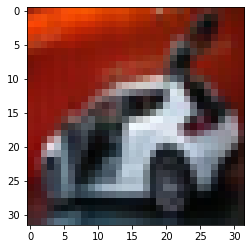

nearest images


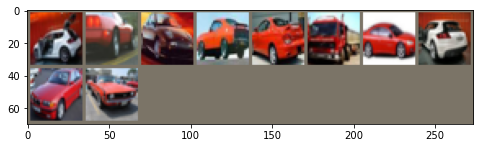

query image


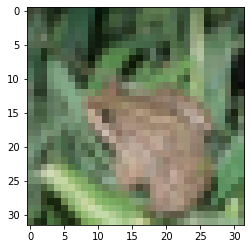

nearest images


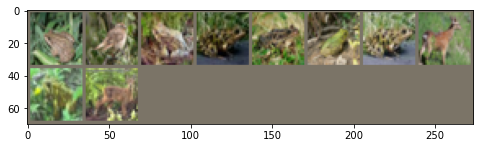

In [8]:
# get 10 nearest neighbors for a car image
for img_type in [classA, classB]:
    img = dataset[img_type[0]][0].unsqueeze(0)
    print("query image")
    imshow(torchvision.utils.make_grid(img))
    distances, indices = inference_model.get_nearest_neighbors(img, k=10)
    nearest_imgs = [dataset[i][0] for i in indices.cpu()[0]]
    print("nearest images")
    imshow(torchvision.utils.make_grid(nearest_imgs))

## Compare two images of the same class

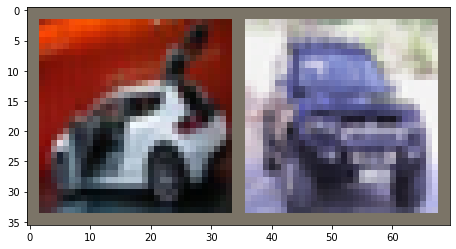

tensor([0.5483], device='cuda:0')
Different class


In [9]:
# compare two images of the same class
(x, _), (y, _) = dataset[classA[0]], dataset[classA[1]]
imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare two images of different classes

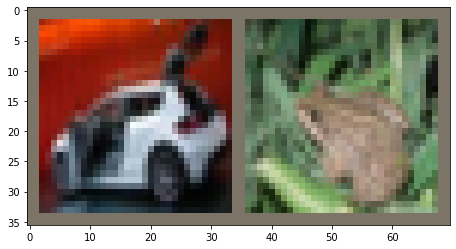

tensor([0.1676], device='cuda:0')
Different class


In [10]:
# compare two images of a different class
(x, _), (y, _) = dataset[classA[0]], dataset[classB[0]]
imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare multiple pairs of images

In [13]:
decision

(array([False, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False, False,
         True, False]),
 array([0.52775997, 0.3055332 , 0.46701825, 0.611935  , 0.292662  ,
        0.7860141 , 0.400769  , 0.45711806, 0.814855  , 0.59323615,
        0.36454284, 0.27080715, 0.6967124 , 0.40142   , 0.3998518 ,
        0.5395633 , 0.32179344, 0.39762467, 0.7556628 , 0.3430068 ],
       dtype=float32))

0.88


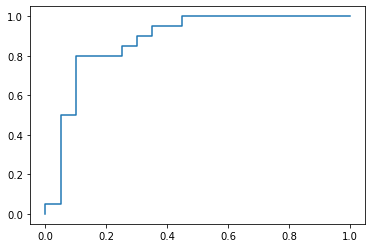

In [31]:
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
y_true=np.tile([1,0],[20])
y_pred=metric_values
print(roc_auc_score(y_true,y_pred))
fpr,tpr,th=roc_curve(y_true,y_pred)
plt.plot(fpr,tpr)

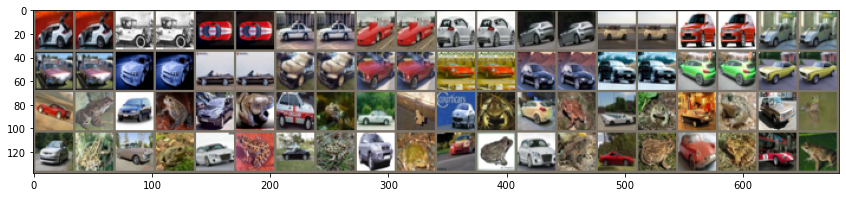

tensor([0.5485, 0.1984, 0.4944, 0.3445, 0.4068, 0.2988, 0.6646, 0.2107, 0.3141,
        0.3520, 0.5710, 0.2942, 0.3498, 0.2697, 0.4860, 0.3168, 0.6009, 0.1642,
        0.5338, 0.5005, 0.5642, 0.4267, 0.4864, 0.1393, 0.6535, 0.2643, 0.4488,
        0.2814, 0.4547, 0.4073, 0.7108, 0.2157, 0.5707, 0.2777, 0.4572, 0.4223,
        0.4087, 0.4248, 0.6032, 0.6688], device='cuda:0')
Different class
metric_value: 0.54846144
Different class
metric_value: 0.19843425
Different class
metric_value: 0.49436587
Different class
metric_value: 0.34454197
Different class
metric_value: 0.40680993
Different class
metric_value: 0.2988163
Different class
metric_value: 0.6646199
Different class
metric_value: 0.21074912
Different class
metric_value: 0.31413186
Different class
metric_value: 0.35204825
Different class
metric_value: 0.5709598
Different class
metric_value: 0.29420936
Different class
metric_value: 0.3497529
Different class
metric_value: 0.2696612
Different class
metric_value: 0.48597935
Different cl

In [29]:
# compare multiple pairs of images
x = torch.zeros(40, 3, 32, 32)
y = torch.zeros(40, 3, 32, 32)
for i in range(0, 40, 2):
    x[i] = dataset[classA[i]][0]
    x[i + 1] = dataset[classA[i]][0]
    y[i] = dataset[classA[i + 19]][0]
    y[i + 1] = dataset[classB[i + 19]][0]
imshow(torchvision.utils.make_grid(torch.cat((x, y), dim=0), nrow=20), figsize=(30, 3))
decision, metric_values = inference_model.is_match(x, y, return_metric_values=True)
for i,d in enumerate(decision):
    print_decision(d)
    print("metric_value:",metric_values[i])
print("accuracy = {}".format(np.sum(decision) / len(x)))

## Compare all pairs within a batch

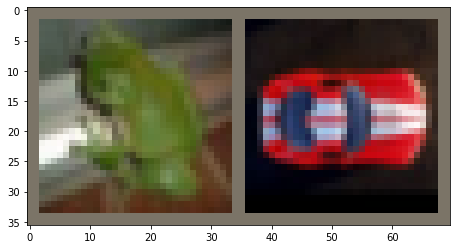

Different class


In [56]:
# compare all pairs within a batch
match_matrix = inference_model.get_matches(x)
assert match_matrix[0, 0]  # the 0th image should match with itself
imshow(torchvision.utils.make_grid(torch.stack((x[3], x[4]), dim=0)))
print_decision(match_matrix[3, 4])  # does the 3rd image match the 4th image?

## Compare all pairs between queries and references

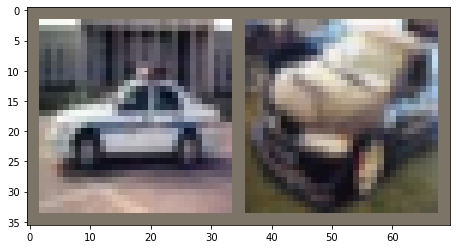

Different class


In [57]:
# compare all pairs between queries and references
match_matrix = inference_model.get_matches(x, y)
imshow(torchvision.utils.make_grid(torch.stack((x[6], y[6]), dim=0)))
print_decision(match_matrix[6, 6])  # does the 6th query match the 6th reference?

# Get results in tuple form

MATCHING IMAGE PAIRS
3 5


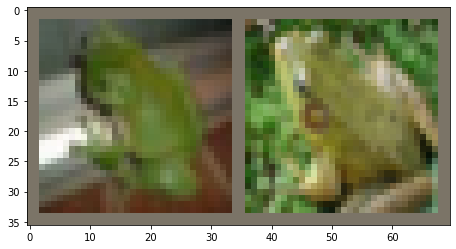

7 3


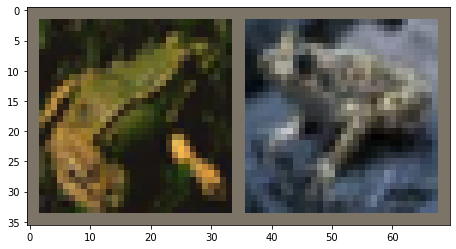

10 12


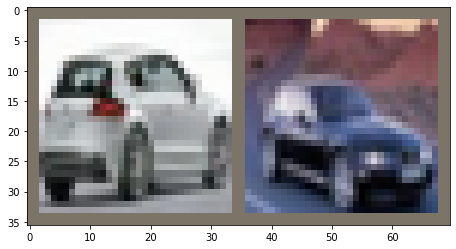

12 14


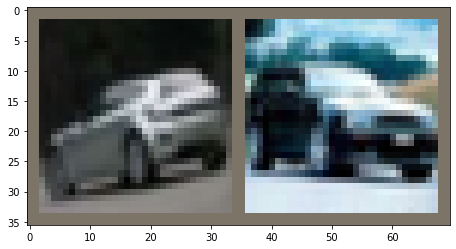

13 3


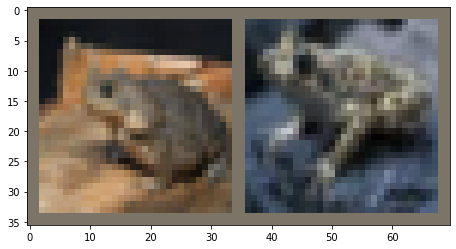

13 5


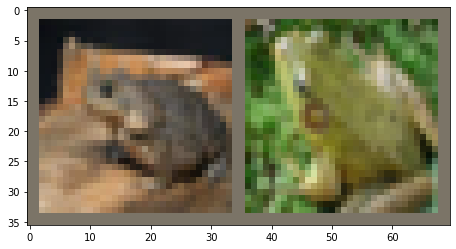

16 18


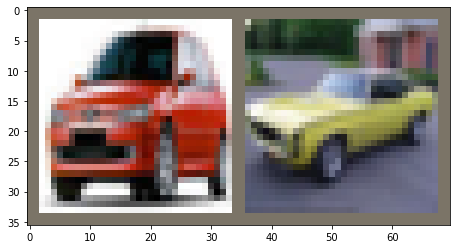

17 3


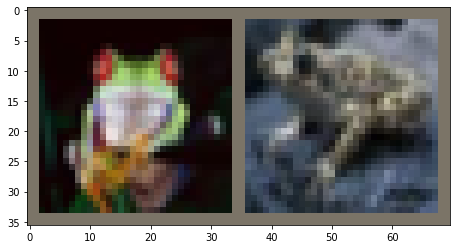

17 5


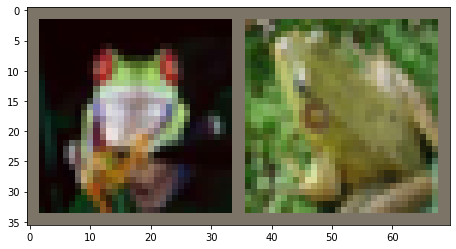

18 8


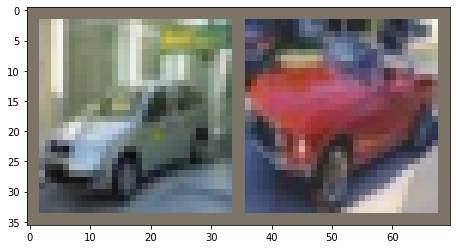

18 10


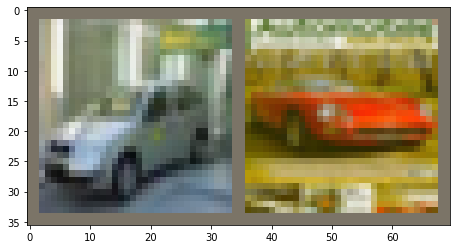

18 18


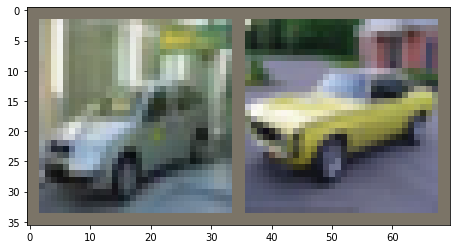

In [13]:
# make a new model with high threshold
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.95)
inference_model = InferenceModel(model, match_finder=match_finder)

# get all matches in tuple form
match_tuples = inference_model.get_matches(x, y, return_tuples=True)
print("MATCHING IMAGE PAIRS")
for i, j in match_tuples:
    print(i, j)
    imshow(torchvision.utils.make_grid(torch.stack((x[i], y[j]), dim=0)))